In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import xlwings as xw
from openpyxl import Workbook, load_workbook
import numpy as np
import seaborn as sns

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


In [2]:
wb=load_workbook('Monte_carlo.xlsx')
sheet=wb['Model Parameters']
sheet1=wb['Model']

In [3]:
n_sims=sheet['B2'].value

COGS_avg=sheet['B6'].value
COGS_std=sheet['B7'].value

Mode_units=sheet['B14'].value
Low_units=sheet['B15'].value
High_units=sheet['B16'].value
sims=int(n_sims)

In [4]:
# prios beliefs about the model parameters distributions
selling_price_avg = sheet['B3'].value
selling_price_std = sheet['B4'].value

COGS_avg=sheet['B6'].value
COGS_std=sheet['B7'].value

SG_A=sheet['B9'].value

Mode_units = sheet['B14'].value
Low_units = 100
High_units = 15500


units_mean = 2500
units_vol = 700

In [5]:
SG_A

0.03356284914420895

In [6]:
UNITS_FIXED=2693

In [7]:
oberver_data_sp = [c[0].value for c in sheet1['C8:C19']]
oberver_data_units = np.random.random_integers(low=Low_units, high=High_units, size=12)
oberver_data_unit_cogs = [c[0].value for c in sheet1['E8:E19']]

/tmp/ipykernel_3874848/2801024281.py:2: DeprecationWarning: This function is deprecated. Please call randint(100, 15500 + 1) instead
  oberver_data_units = np.random.random_integers(low=Low_units, high=High_units, size=12)


In [8]:
oberver_data_units

array([ 1624,  3382, 11260, 15029,  9547, 10091,  5946,  8715,  1518,
       13758, 13749, 12058])

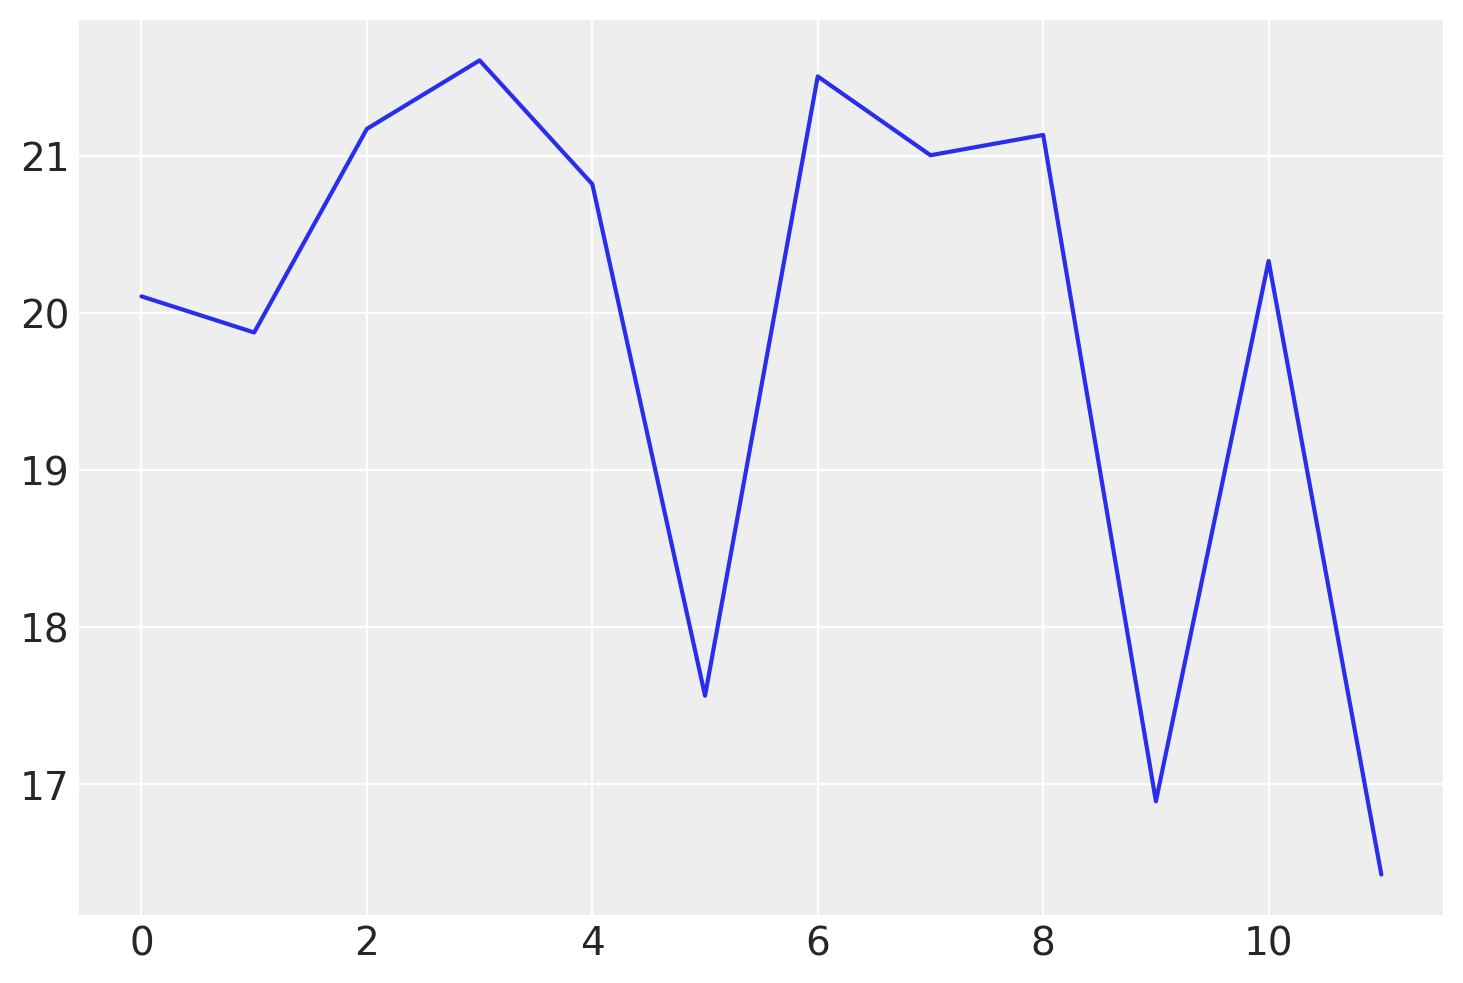

In [9]:
_ = sns.lineplot(oberver_data_sp)

In [10]:
SAMPLES = 50000
BURN = 10000
SEED=1991


model_sp = pm.Model()
model_cogs = pm.Model()
model_units = pm.Model()


with model_sp:

    # Priors for unknown model parameters
    #priors selling price
    sell_price_prior_mean = pm.Normal('sp_mean', mu=selling_price_avg, sd=selling_price_std*1.5)
    sell_price_prior_vol = pm.HalfNormal('sp_std', sd=selling_price_std)
    
    
    likelihood_selling_price = pm.Normal(
        'selling_price', 
        mu=sell_price_prior_mean, sd=sell_price_prior_vol, observed=oberver_data_sp)
    
    step = pm.Metropolis()
    trace_sp = pm.sample(SAMPLES, tune=BURN, step=step, random_seed=SEED)

with model_cogs:
             
    #priors cogs
    cogs_prior_avg = pm.Normal('cogs_mean', mu=COGS_avg, sd=COGS_std*1.5)
    cogs_prior_std = pm.HalfNormal('cogs_std', sd=COGS_std)
    
    likelihood_cogs = pm.Normal(
        'unit_cogs', 
        mu=cogs_prior_avg, sd=cogs_prior_std, 
        observed=oberver_data_unit_cogs)
    step = pm.Metropolis()
    trace_cogs = pm.sample(SAMPLES, tune=BURN, step=step, random_seed=SEED)

with model_units: 
    #prior units
    units_soldp_mean= pm.Normal('units_mean', mu=units_mean, sd=units_vol*1.5)
    units_soldp_vol = pm.HalfNormal('units_vol',sd=units_vol)
    
    likelihood = pm.Normal('units_sold', mu=units_soldp_mean, sd=units_soldp_vol, observed=oberver_data_units)
    
    step = pm.Metropolis()
    trace_units = pm.sample(SAMPLES, tune=BURN, step=step, random_seed=SEED)
    
    

/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sp_std]
>Metropolis: [sp_mean]


Sampling 2 chains for 10_000 tune and 50_000 draw iterations (20_000 + 100_000 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [cogs_std]
>Metropolis: [cogs_mean]


Sampling 2 chains for 10_000 tune and 50_000 draw iterations (20_000 + 100_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [units_vol]
>Metropolis: [units_mean]


/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 2 chains for 10_000 tune and 50_000 draw iterations (20_000 + 100_000 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot: title={'center': 'units_mean'}>,
       <AxesSubplot: title={'center': 'units_vol'}>], dtype=object)

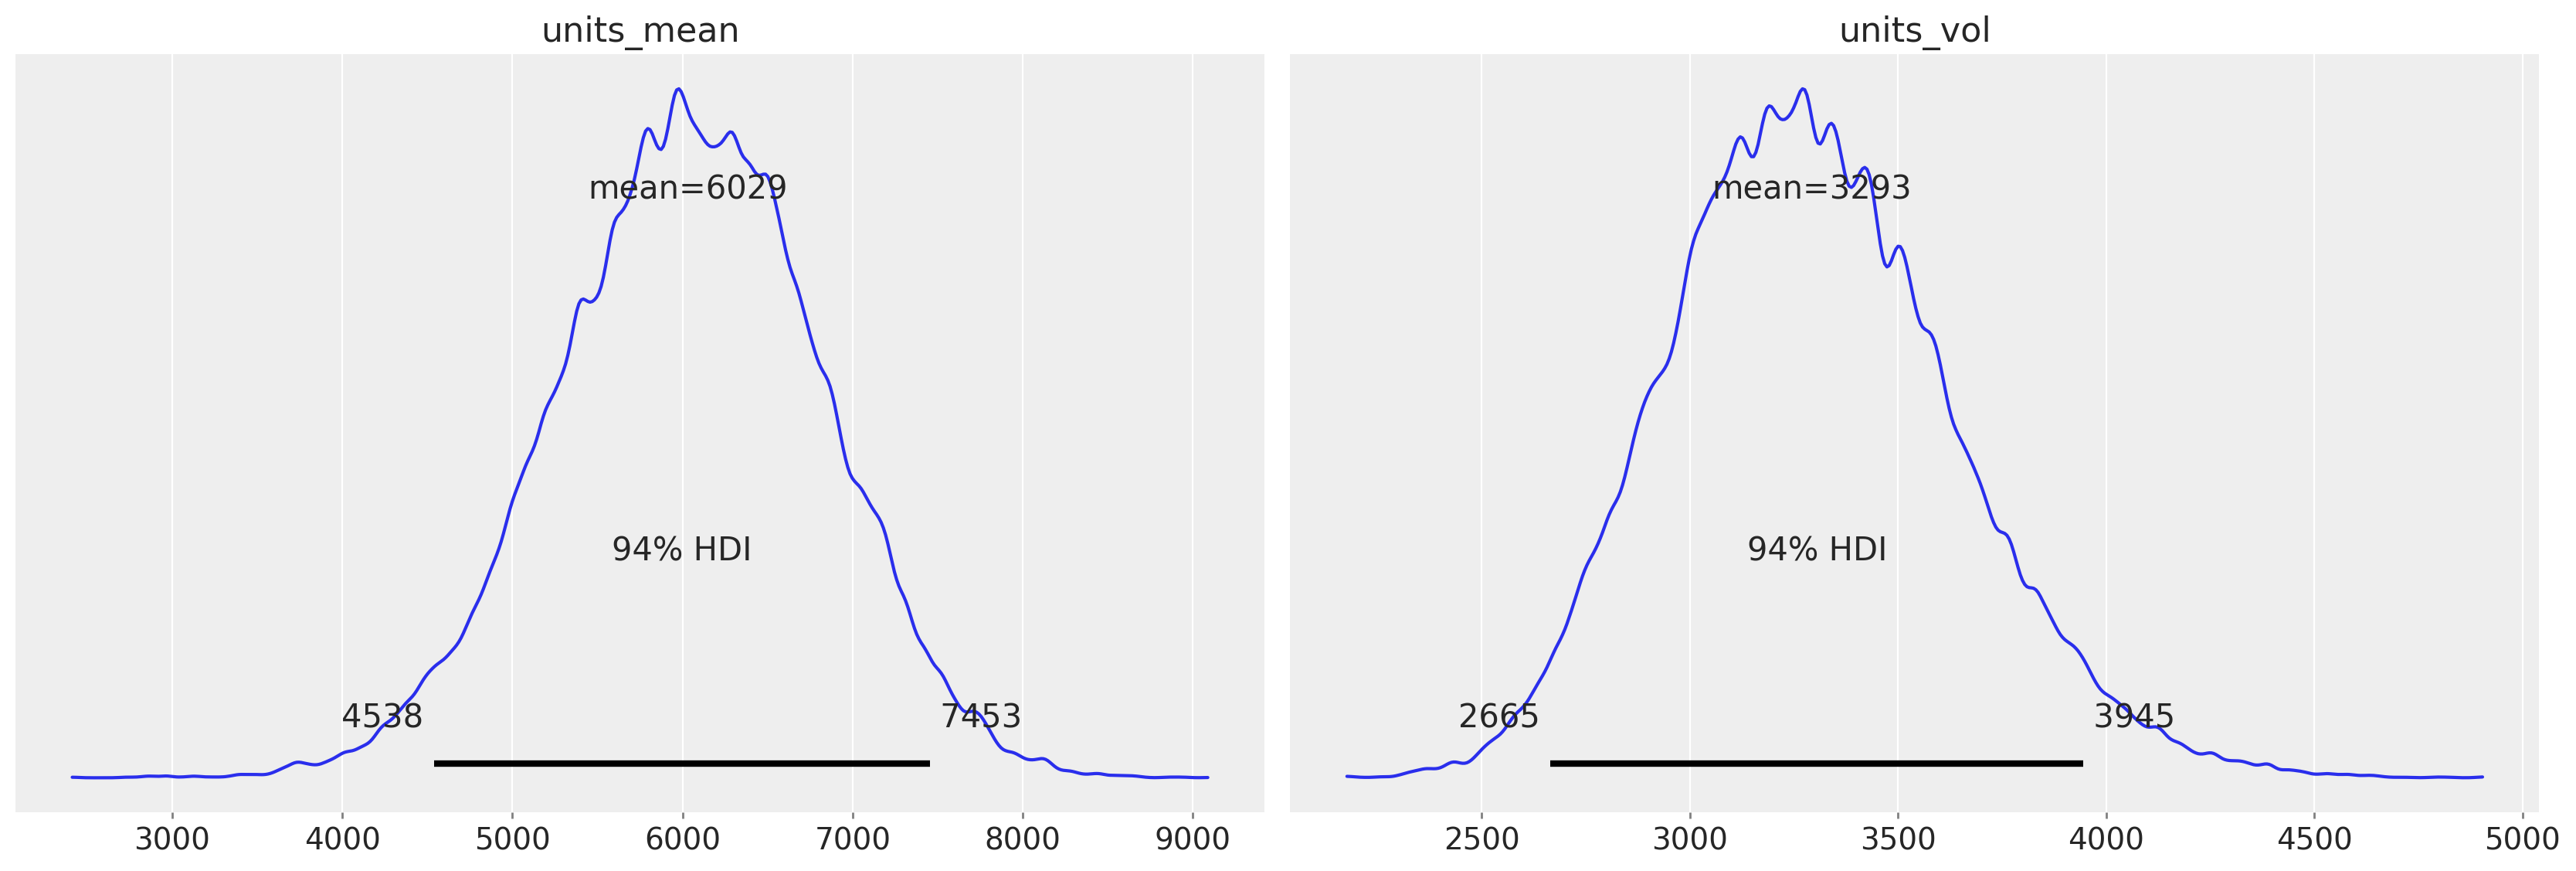

In [11]:
az.plot_posterior(trace_units, round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'units_mean'}>,
        <AxesSubplot: title={'center': 'units_mean'}>],
       [<AxesSubplot: title={'center': 'units_vol'}>,
        <AxesSubplot: title={'center': 'units_vol'}>]], dtype=object)

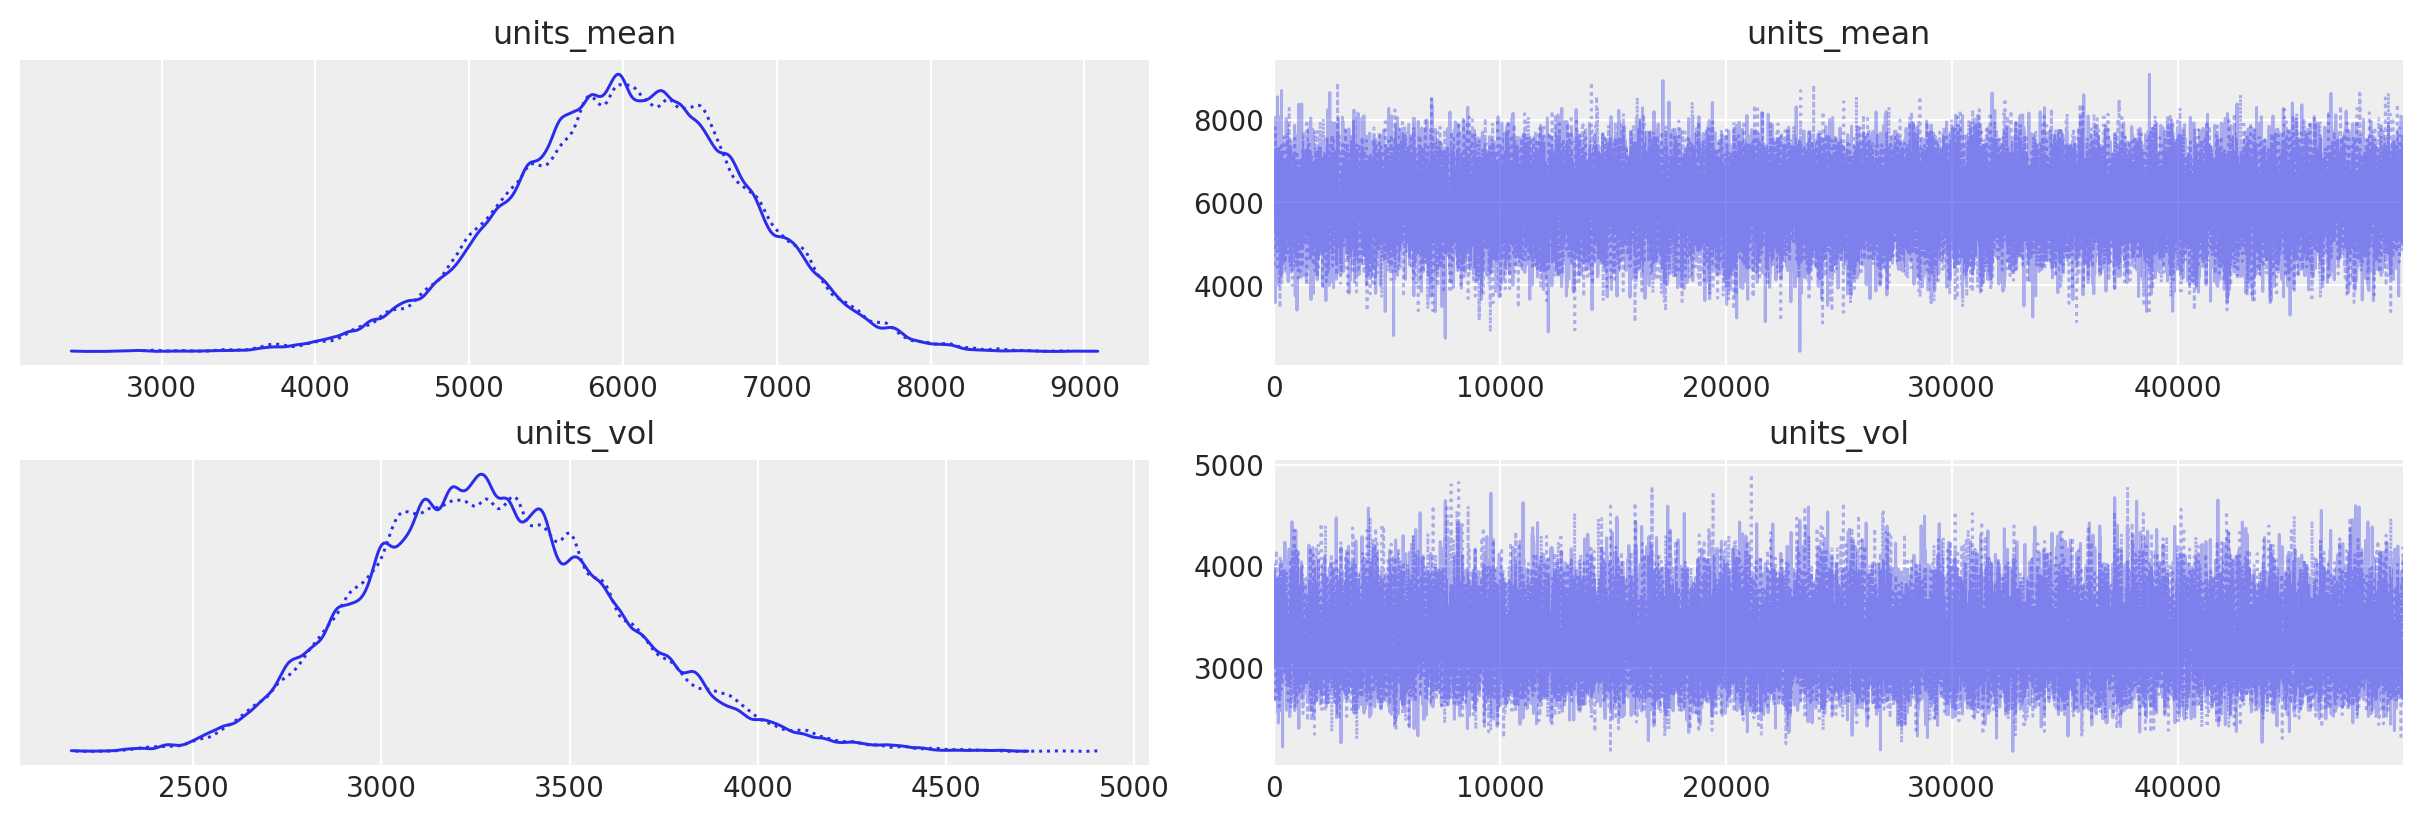

In [12]:
az.plot_trace(trace_units)

In [13]:
post_samples_cogs = pm.sampling.sample_posterior_predictive(trace_cogs, samples=1000, model=model_cogs, random_seed=42)['unit_cogs']
post_samples_sp = pm.sampling.sample_posterior_predictive(trace_sp, samples=1000, model=model_sp, random_seed=42)['selling_price']
post_samples_units = pm.sampling.sample_posterior_predictive(trace_units, samples=1000, model=model_units, random_seed=42)['units_sold']

/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [14]:
post_sg_a_prct = np.random.uniform(low=0.01, high=0.1, size=1000)

In [63]:

revenue_sim = (post_samples_units*post_samples_sp)
total_cogs = (post_samples_units*post_samples_cogs)
gross_margin = (revenue_sim+total_cogs)
sg_a = (post_sg_a_prct*np.ones((12,1000))).T*gross_margin
ebitda_pro = (gross_margin-sg_a)

In [64]:
(post_sg_a_prct*np.ones((12,1000))).shape

(12, 1000)

In [67]:
ebitda_pro.sum(axis=1)/1000000

array([2.69842499, 1.18175462, 1.82187528, 1.64911348, 2.12578812,
       2.59066295, 1.97648465, 1.69688467, 2.00362404, 2.99711515,
       2.75093212, 2.69450404, 2.66491518, 3.73768099, 3.40886353,
       2.61300617, 3.00481419, 3.71160017, 2.59993924, 2.74517526,
       2.88719403, 2.93429564, 2.68270462, 2.92983089, 2.90274194,
       2.96186848, 3.49132081, 2.86867964, 2.19041295, 2.39791349,
       2.75366394, 2.72189691, 2.84621774, 1.73253814, 2.27098408,
       2.16126824, 1.82167383, 1.49329858, 1.83272788, 2.41078096,
       1.67690981, 1.41596027, 0.88275324, 0.81071157, 0.84556953,
       1.21859179, 3.34184338, 2.792297  , 2.72610767, 2.24481493,
       2.81380822, 3.09418742, 2.39132674, 1.81679496, 3.07170465,
       2.09859774, 2.04488033, 2.75817805, 2.56746012, 2.74396185,
       2.21702762, 2.93067009, 2.26928162, 3.23480303, 2.70638578,
       2.84156524, 2.7874457 , 2.79780873, 3.68828396, 2.01740072,
       2.43540159, 2.79922323, 2.43021266, 3.02662176, 2.90576

In [69]:
ebitda_scaledv = ebitda_pro.sum(axis=1)/1000000

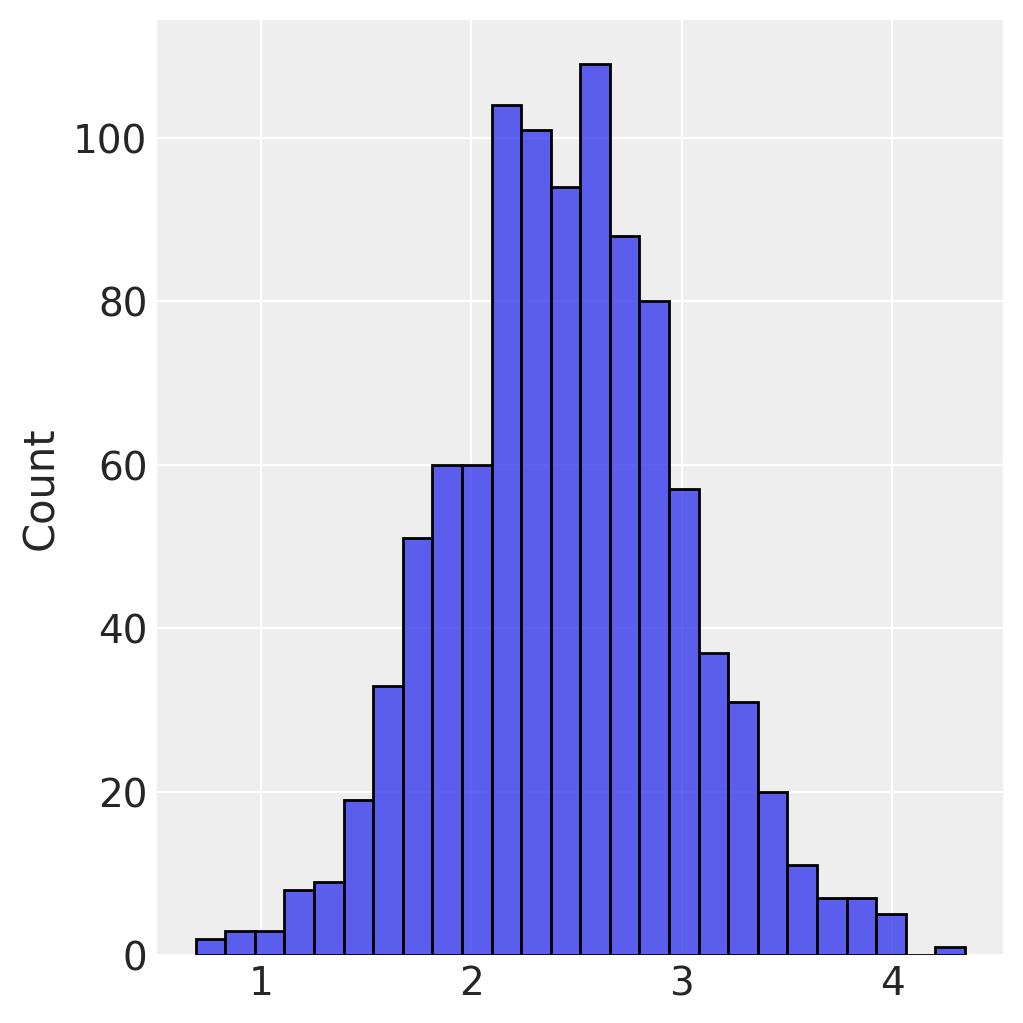

In [70]:
sns.displot(ebitda_scaledv)

In [ ]:
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(None, posterior["a"].mean(), posterior["b"].mean()), linewidth=3)
for i in np.random.randint(0, size, 75):
    sim = competition_model(None, posterior["a"][i], posterior["b"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

<AxesSubplot: >

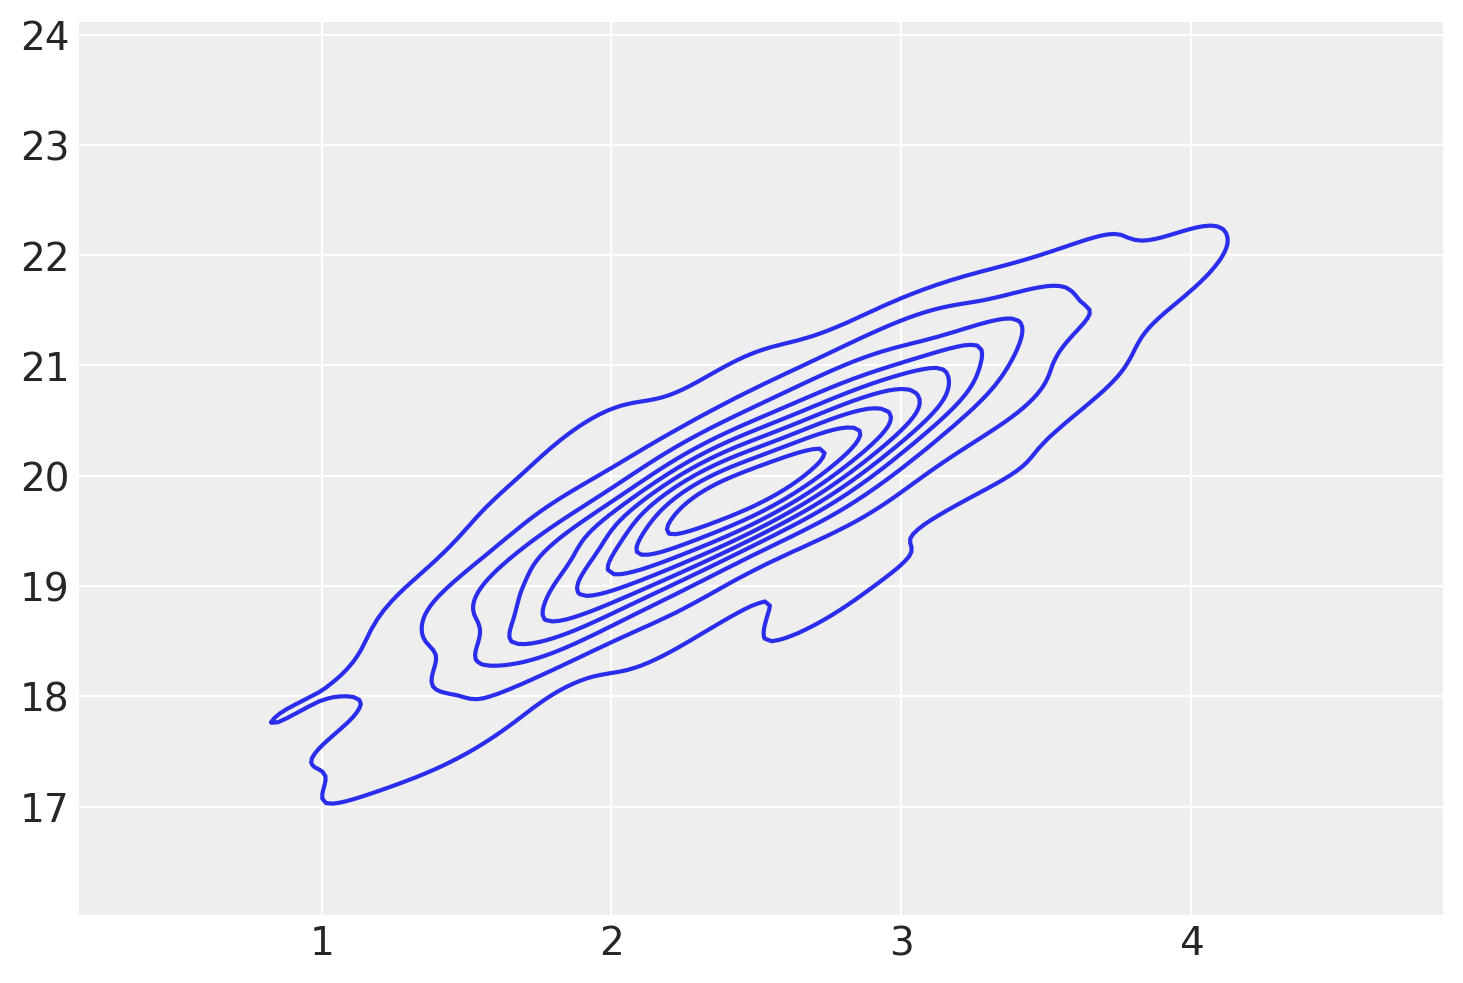

In [77]:
sns.kdeplot(x=ebitda_scaledv, y= post_samples_sp.mean(axis=1))

<AxesSubplot: >

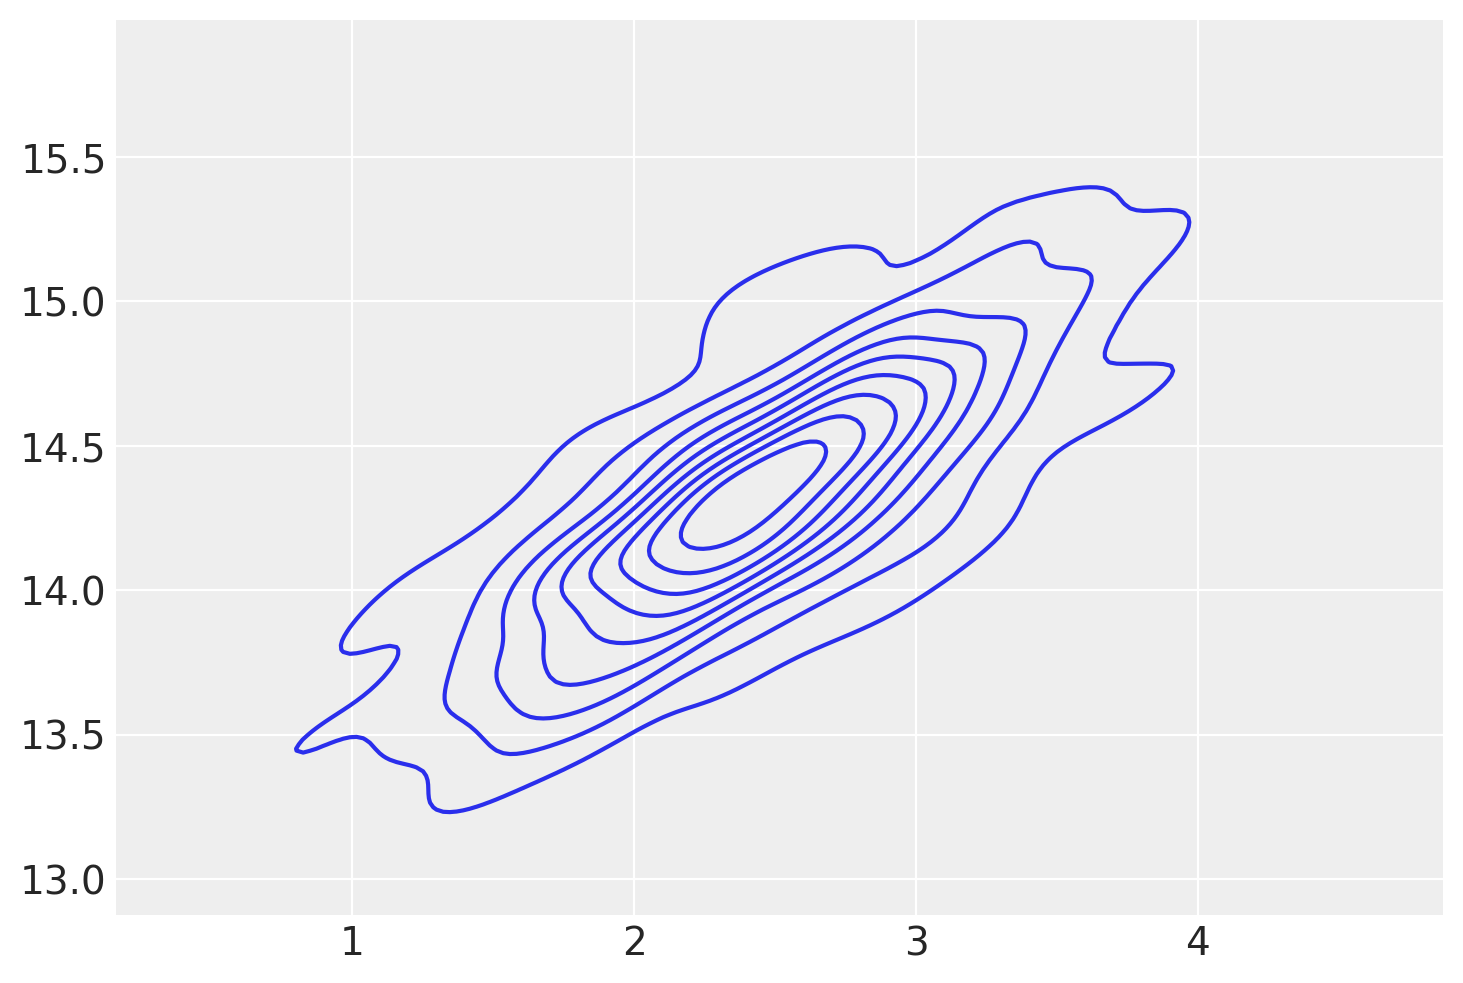

In [81]:
sns.kdeplot(x=ebitda_scaledv, y= post_samples_cogs.mean(axis=1))